# MinPrimeHitSet Experiments

This notebook will include the outcome of a number of experiments preformed utilising the methods I have conjured up elsewhere. It might stray into unprofessional territory in the commentary at times so brace yourself for that I guess ey lads ;)

some general bits I hope to tick off are:

- test on small number of integers within a small range
- test on small number of integers within a big range
- test on large number of integers in a small range
- test on large number of integers in a big range
- test on some number of  explicitly non-prime integers
- test on some input data where the true solution does not include the number 2
- test where the line between the various types of input data might actually lie

and maybe some more Ill add to these over time. I'm hoping that I will be able to deduce the best algorithms for each scenario and compare utility using this method. Going in my biggest interest is with comparison of **Grdy** to **Xstv** but Theres some amount of intrguige to how the remaining algorithms will preform too.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
import os
import json
from collections import Counter
from timeit import default_timer as timer
from hit_set_algorithms import minimum_prime_hitting_set  # this is the single call used to run all the available algs
from shared_functions import get_prime_decomposition_list

%matplotlib inline

# Initial preformance test - small number of integers in a small range

to start with we'll compare run times and accuracy for running the algorithm on a fairly small number of integers. these ints will be of size < 1000 to try to keep the number of possible primes in play minimal, but we'll still need enough variety to require the algorithms at all (i.e. it needs to get at the self solve portion of the algorithms in order to test the unique endings)

to start with I'll set up a very basic test where 20 random ints will go in a single time to every algorithm. I hope this will help set expectations of preformance for each, as well as prove to me that they all work as intended lol.

In [9]:
random.seed(34)  # ensure reproducibility of result

input_list = random.sample(range(0, 1000), 20)
input_list

[541,
 365,
 599,
 28,
 863,
 234,
 920,
 30,
 903,
 398,
 373,
 977,
 971,
 66,
 434,
 978,
 313,
 349,
 96,
 598]

looks reasonable to my untrained eyes, though i think a fair few of these ints are prime / primes$^{n}$ already. 

First off, I'll just run this list through all the algorithms, and see what they output and with what speeds to get a feel for the initial preformance of each.

In [10]:
algs_to_run = ['self-solve', 'random', 'exhaustive', 'greedy', 'stochastic', 'multiple-stochastic', 'genetic']
sols = {}

for alg in algs_to_run:
    print('\nattempting to solve problem using \033[1m{}\033[0;0m algorithm'.format(alg))
    
    # the weird codes in the text make the alg name print bold to help me skim read. no idea what they actually mean tho :O
    
    start = timer()
    output_vals = minimum_prime_hitting_set(input_list, alg)
    end = timer()

    print('\n\t{} algorithm ran in {}'.format(alg, str(end - start)))
    print('\tsolution formed is of length {}'.format(len(output_vals)))
    
    sols[alg] = output_vals
    
    print('\n------------------------------------------------------------------------')


attempting to solve problem using self-solve algorithm

decomposing input integers...

checking if problem solved without need for chosen algorithm...

partial solution = [971, 977, 373, 599, 313, 349, 541, 863]

	self-solve algorithm ran in 0.00104810000004818
	solution formed is of length 8

------------------------------------------------------------------------

attempting to solve problem using random algorithm

decomposing input integers...

checking if problem solved without need for chosen algorithm...


---| Running Chaotic Random Minimum Prime Hitting Set Algorithm |---

	MinHitSet complete! solution = [2, 3, 5, 13, 313, 349, 373, 541, 599, 863, 971, 977]

	random algorithm ran in 0.0013360000000375294
	solution formed is of length 12

------------------------------------------------------------------------

attempting to solve problem using exhaustive algorithm

decomposing input integers...

checking if problem solved without need for chosen algorithm...


---| Running Exh

a successful test! - worth noting that self-solve component of the runs already discovered 8 of the 11 integers contained in the solution so minimal actual use for each algorithm to solve. whilst its obviously dumb to start judging algorithm quality based on this one individual test I think the general assumptions i've had about each going in have been well exemplified by this (i.e. run time of multiple stochastic being longest by far, random and individual stochastic being least accurate.) Sad to see genetic isnt always preforming the best but I'm sure that can be tuned if appropriate as its run time is I'd say supprisingly promising

Also note that multiple stochastic has managed to find a solution which matches the quality of exhaustive but that includes different primes, showing there are multiple possible solutions to this particular case. For my code / experiments I've opted to only ever return one solution in cases where there are multiple, primarily because the length and is all that really matters to us and itll be more annoying to code if sometimes it yields one result and other times multiple. This is a decision I *may* walk back at some point but for now at least I cant see any reason to yield multiple sols. 

# trying and failing to benchmark with Xstv algorithm

OK cool. I think a good place to start with this exploration will be to see how exhaustive preforms over input lists of increasing complexity and see if we can establish some cut off rules for where it would be inaaporpriate to utilise this algorithm. From here we can begin to examine which algorithms make sense in each edge case. The method I prupose using for this is as follows:

1. pick a range 
2. generate a list of length n containing random integers sampled without replacement from the range
3. run the algorithm on the list, noting the run time.

ideally, we'd want to sample and run many random lists of length n and take their average run time as chance will dictate how much of a given input list is solved automatically right from the start. the size of n both in raw terms and potentially as a proportion of the size of the range is also likely to be an inportant factor, so I propose using multiple values for n and seeing how the algorithms behave. my guss going in is that initially as n increases, the average runtime of the algorithms will increase, until we pass some hump after which point the average run time will drop off rapidly. I dont expect this to hold for greedy or random however, instead i anticipate random having a fairly uniform run time, whilst greedy should be linear. I'm not sure what to make of genetic as its runtime is based on chance to a large extent so anything could really happen there.

10
20
30
40


<AxesSubplot:xlabel='input_length'>

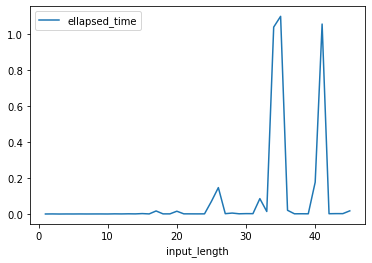

In [39]:
times = {}

for n in range(1, 45):
    if n % 10 == 0:
        print(n)
    
    input_list = random.sample(range(0, 1000), n)

    start = timer()
    minimum_prime_hitting_set(input_list, 'exhaustive', text=False)
    end = timer()

    runtime = end - start 
    
    times[str(n)] = runtime

times_df = pd.DataFrame(times, index=['time']).transpose().reset_index()
times_df.columns = ['input_length', 'ellapsed_time']
times_df['input_length'] = times_df.index + 1

times_df.plot(x='input_length', y='ellapsed_time')

so immediatley hit the issue with exhaustive method here, namely that for certain input lists (presumably ones with few primes and little overlap in divisors?) it just absolutely melts the laptop and / or outputs nothing in feasible time. this will make experimenting sadly harder than anticipated for these cases. I hope therefore that the other algorithms behave reasonably well in terms of runtime or we coudl hit some major hurdles here. not having access to exhaustive algorithms for certain ranges / input list lengths will be a bummer as its the only algorithm garunteed to output the true solution but at least we can still emasure the remaining algorithms against each other if not the truth. 

until the driver melted even the longest run took only a second so its hard to really know whats going so horribly wrong here hahaha. to be fair though, the longest run time does represent more than 1000x the average runtime...

I wonder if we just reduce the range the sample comes from we migth dodge all this shenaniganary?

10
20
30
40
50
60
70
80
90


<AxesSubplot:xlabel='input_length'>

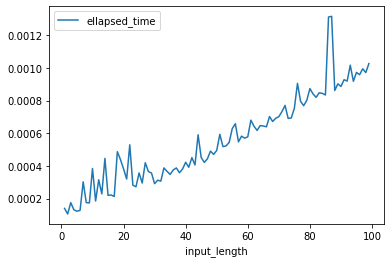

In [6]:
times = {}

for n in range(1, 100):  # small range this time, to be extra sure
    if n % 10 == 0:
        print(n)
    
    runtime = []
    
    for i in range(5):
        input_list = random.sample(range(0, 100), n)

        start = timer()
        minimum_prime_hitting_set(input_list, 'exhaustive', text=False)
        end = timer()

        runtime.append(end - start) 
    
    avg_runtime = statistics.mean(runtime)  # average runtime of five runs - we should probably run more to smooth this out!
    times[str(n)] = avg_runtime

times_df = pd.DataFrame(times, index=['time']).transpose().reset_index()
times_df.columns = ['input_length', 'ellapsed_time']
times_df['input_length'] = times_df.index + 1

times_df.plot(x='input_length', y='average_ellapsed_time')

ok yeah much better, all ran near instantly. I think probably what we'll do net is to try running all of these bitches all at once and plot similar graphs. one thing that is interesting here is that we dont see the curve and then rapid drop to the run time of the algorithm, which I really expected.

# testing runtimes for all algorithms on the range 0, 150

next I'll see what happens when i run them all just because. I will also generate length of output solution whilst doing this, but I wont actually use it until a bit later on so try not to get too antsy in your pantsy over that :)

In [11]:
algs_to_run = ['random', 'exhaustive', 'greedy', 'stochastic', 'multiple-stochastic', 'genetic']
times = {i: [] for i in algs_to_run}
lengths = {i:{j:[] for j in range(1, 150)} for i in algs_to_run}

for n in range(1, 150):
    if n % 10 == 0:
        print(n)
    
    runtime = {i: [] for i in algs_to_run}
    
    for i in range(20):
        input_list = random.sample(range(0, 150), n)
        
        for key in times.keys():
            start = timer()
            sol = minimum_prime_hitting_set(input_list, key, text=False)
            end = timer()
            runtime[key].append(end - start) 
            lengths[key][n].append(len(sol))
    
    for key in times.keys():
        times[key].append(statistics.mean(runtime[key]))

if not os.path.isdir('experiment_output_data'):
    os.mkdir('experiment_output_data')
    
with open('experiment_output_data/runtimes_150.json', 'w') as fp:
    json.dump(times, fp)
with open('experiment_output_data/lengths_150.json', 'w') as fp:
    json.dump(lengths, fp)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


wow that really guzzled memory if not time lol. laptop was getting roudy and warm so i restarted the kernel just to be safe. I'm not honestly 100% sure what we can do to compare the lengths right now, but we can at least plot the average runtimes as a multiline graph. to be honest I'm not expecting to see much crazy here but maybe ill be low key supprised by the results...?

In [12]:
df = pd.read_json('experiment_output_data/runtimes_150.json')

df.head()

,random,exhaustive,greedy,stochastic,multiple-stochastic,genetic
0,0.000025,0.000024,0.000023,0.000044,0.000025,0.000027
1,0.000045,0.000044,0.000043,0.001185,0.002756,0.000106
2,0.000061,0.000051,0.000052,0.003619,0.018336,0.000455
3,0.000072,0.000060,0.000063,0.004422,0.024025,0.000658
4,0.000090,0.000080,0.000080,0.003978,0.019768,0.000737


<AxesSubplot:>

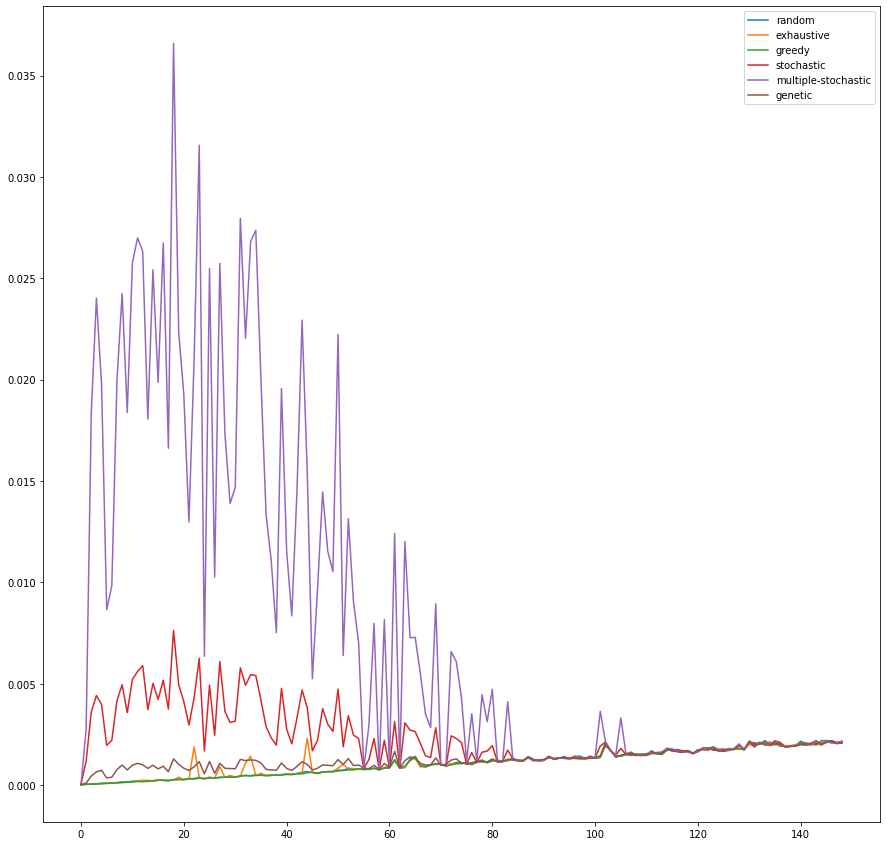

In [13]:
df.plot(figsize=(15, 15))

ok, so i think what we see here is kind of what I expected to happen before, namely that once you get a certain level of coverage, the algorithm just solves itself the vast majority of the time. This is demonstrated by the sudden and significant drop off in run time volatility in stochastic and multiple stochastic algorithms which could be said to have occured as at that point, all algorithms are solved prior to needing to ever be activated. this could be confirmed by checking the lengths for this value.

its interesting to me to see exhaustive, greedy and random holding on to effectively identical run times, especiall since if anything i anticipted random to have a uniform run time over the period. 

I would just quickly like to see each graph separately too, too view individual volitility when divorced from the hectic start the stochastic algorithms had:

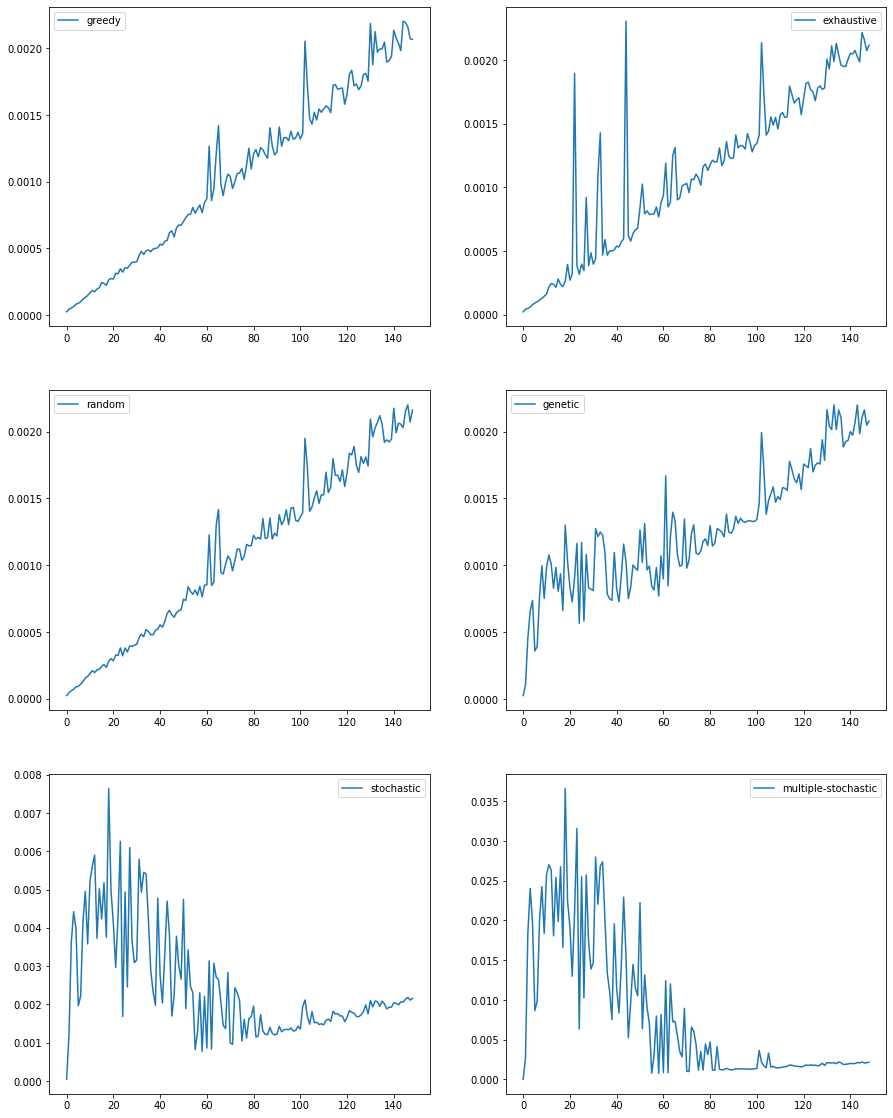

In [16]:
line_graph_cols = [('greedy', [0, 0]), 
                   ('exhaustive', [0, 1]),
                   ('random', [1, 0]),
                   ('genetic', [1, 1]),
                   ('stochastic', [2, 0]),
                   ('multiple-stochastic', [2, 1])]

fig, ax = plt.subplots(3, 2, figsize=(15, 20))

for col_tuple in line_graph_cols:
    df.plot(y=col_tuple[0], ax=ax[col_tuple[1][0], col_tuple[1][1]])

ok yeah, i think maybe if id run each more times over we'd see a much more consistant graph after around the 60 mark for most of the included algorithms.

It is interesting to see the spikes in exhaustive compared to the much more consistant greedy or random algorithms, which both execute in strictly linear time when called upon, as expected. the two stochastic algorithms are batshit insane, also as expected due to the random nature of their runtimes. I'd imagine with more runs the volatility would depreciate, leaving us with higher then normal but less kooky average run times, probably follwing a similar curve to the one we see forming. This is the curve I actually expected exhaustive to take being honest but guess thats not how it worked out. the genetic algorithm is very much its own beast here, not really behaving in an inkeeping way with any of the others. That one was coded just because I oculd so I'm not too concerned there.

# Testing error on the (0, 150) range

next we'll see how accurate we were on the same range. luckily, since exhaustive search was successfull for all the values here we know the true lenght of the minimum so can simply compare each algorithms length values to the length of that one to get an idea of the error.

In [8]:
with open('experiment_output_data/lengths_150.json') as json_file:
    lengths = json.load(json_file)
    
base_len = lengths['exhaustive']  # exhaustive garuntees the minimum length so can use it as the 'truth' here.
error = {i: [] for i in lengths.keys()}

for algorithm in lengths.keys():
    alg = lengths[algorithm]
    for key, value in alg.items():
        true_len = sum(base_len[key])
        achieved_len = sum(value)
        error[algorithm].append(achieved_len - true_len)
        
with open('experiment_output_data/errors_150.json', 'w') as fp:
    json.dump(error, fp)
    
for key in error.keys():
    print('\nThe total error of the {} algorithm over the range was {}'.format(key, sum(error[key])))


The total error of the random algorithm over the range was 126

The total error of the exhaustive algorithm over the range was 0

The total error of the greedy algorithm over the range was 2

The total error of the stochastic algorithm over the range was 98

The total error of the multiple-stochastic algorithm over the range was 18

The total error of the genetic algorithm over the range was 16


pretty decent and to be fair quite in line with what we expected. I am interested by the error of greedy, as it showcases that the heuristic is not infallible which to be honest I wasnt fully convinced it wouldnt always work. My initial plan wa to plot error as lines, and maybe average rather than raw sum but looking at these numbers im not sure how useful that will be...?

guess it wouldnt hurt to at least plot the multiline graph. I wont be bother to get average error since the shape of the plot is all I'm interested in here and average will be identically shaped just without whole numbers on the axis:

<AxesSubplot:>

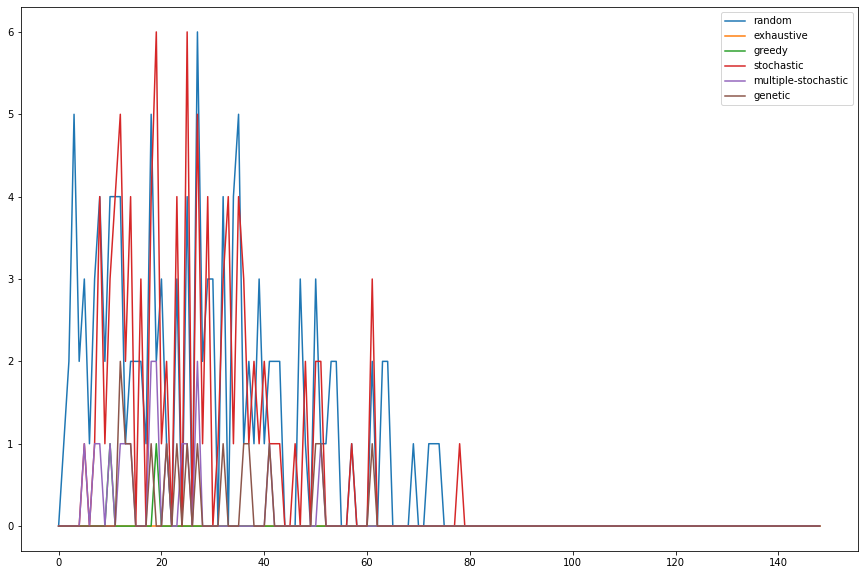

In [13]:
df = pd.read_json('experiment_output_data/errors_150.json')

df.plot(figsize=(15, 10))

interesting to be fair - I was expecting all flat from around 40-50 based on the other graphs. This shows that at least some of the time we arent self solving for as much as beyond the half way mark. I guess we just have so few primes left to find that most algorithms still see no error at this point except the more crap ones.

# picking a new, less crap range

I think my next experiment will be to move the range to no longer include the first 100 integers. this is because of the prime number density in this range which i believe leads to the rapid drop off at around 50% coverage of the range. to that end picking a range which includes as few primes as possible would be an interesting experiment, however it could lead to frazzled laptops so i think we'll build up to it. In order to decide on a reasonable range I'll plot a few candidates bellow in a variety of means to get a feel for their structure / makeup, starting with the range we just used


decomposing input integers...

number of unqiue primes in decomposition and number of occurances of each prime are...:


<AxesSubplot:>

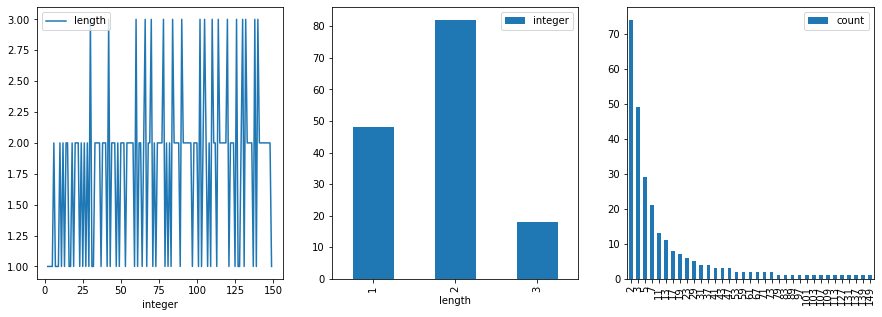

In [55]:
range_1 = range(1, 150)

decomps = get_prime_decomposition_list(range_1, text=True)
decomp_lens = [len(decomp) for decomp in decomps]
decomp_lens = pd.DataFrame({'length': decomp_lens, 'integer': range(2, 150)})

flat_decomps = [item for sublist in decomps for item in sublist]
flat_decomps = Counter(flat_decomps)
flat_decomps = pd.DataFrame(flat_decomps, index=['count'])

print('number of unqiue primes in decomposition and number of occurances of each prime are...:')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
decomp_lens.plot(x='integer', y='length', ax=ax[0])
decomp_lens.groupby('length').count().plot(kind='bar', ax=ax[1])
flat_decomps.transpose().plot(kind='bar', ax=ax[2])

the first chart shows the numebr of unique primes in the decompositions of each integer in the range, and from this we learn that none hve more than 3 primes which should severly restrict the oportunity for the algorithm to take too long even for exhaustive search. 

the second is the same information, this time presented as a bar chart where length of bar indicates number of input integers whose decomposition is of a given length. here we learn that in the given range around 1/3 integers is prime or prime^n, which explains why the algorithms all cease to be relevant so early on in our incremental coverage above

the third plot shows the number of occurances of each prime in the decompositions of all the integers. As expected, half of all the values are even so end up divisible by 2. The three next most common divisors are 3, 5 and 7. If every number was divisible by exactly one each of these three, we'd end up with 100% coverage which is interesting i guess...? 
<br>**might want to come back to this Johnno it could be significant**<br> its not at all unexpected that the later primes occur only once each as theyre far too large to occur multiple times and are presumably present only as individual primes. 

from this I guess we'll see how the same graphs plotted for some arbitrary chunks between 150 - 1000 look? 